# Stratify

## Vertical interpolation for numerical weather prediction (NWP) model data

Whilst this is not the only use for the ``stratify`` package, NWP vertical interpolation was the motivating usecase for the package's creation.

In its simplest form, vertical interpolation amounts to a 1d interpolation at each grid-point. Whilst some more sophistication exists for a number of interpolators, ``stratify`` can be seen as an optimisation to vectorize these interpolations beyond naïve nested for-loops.

#### Data setup
In order to setup the problem, let's manufacture some reasonably realistic NWP data.

First, let's randomly generate some orography (or, if this were an ocean model, bathymetry) that we can use for our model:

In [1]:
import numpy as np

nx, ny = 6, 3

np.random.seed(0)
orography = np.random.normal(1000, 600, size=(ny, nx)) - 400
sea_level_temp = np.random.normal(290, 5, size=(ny, nx))

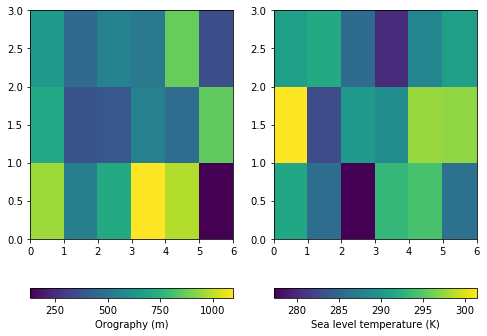

In [2]:
# Now visualise:

import matplotlib.pyplot as plt

plt.set_cmap('viridis')
fig = plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(orography)
cbar = plt.colorbar(orientation='horizontal',
                    label='Orography (m)')
# Reduce the maximum number of ticks to 5.
cbar.ax.xaxis.get_major_locator().nbins = 5

plt.subplot(1, 2, 2)
plt.pcolormesh(sea_level_temp)
cbar = plt.colorbar(orientation='horizontal',
                    label='Sea level temperature (K)')
# Reduce the maximum number of ticks to 5.
cbar.ax.xaxis.get_major_locator().nbins = 5

plt.show()

Next, let's define a vertical coordinate system that minimises missing data values, and gives good resolution at the (orographic) surface.

To achieve this we invent a scheme where the "bottom" of the model closely follows the orography/bathymetry, and as we reach the "top" of the model we get levels of approximately constant height.

In [3]:
nz = 9

model_levels = np.arange(nz)

model_top = 5000  # m

# The proportion of orographic influence on the model altitude. In this case,
# we define this as a log progression from full influence to no influence.
sigma = 1.1 - np.logspace(-1, np.log10(1.1), nz)

# Broadcast sigma so that when we multiply the orography we get a 3D array of z, y, x.
sigma = sigma[:, np.newaxis, np.newaxis]

# Combine sigma with the orography and model top value to
# produce 3d (z, y, x) altitude data for our "model levels".
altitude = (orography * sigma) + (model_top * (1 - sigma))

Our new 3d array now represents altitude (height above *sea* surface) at each of our "model levels".
Let's look at a cross-section of the data to see how these levels:

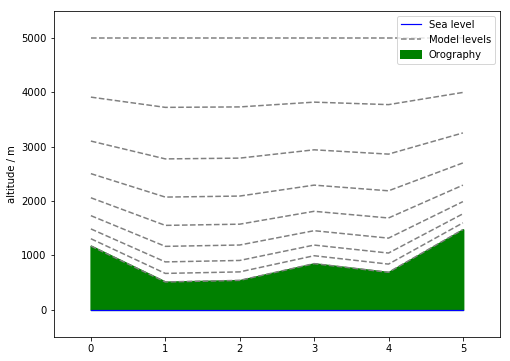

In [4]:
plt.figure(figsize=(8, 6))
plt.fill_between(np.arange(6), np.zeros(6), orography[1, :],
                 color='green', linewidth=2, label='Orography')

plt.plot(np.zeros(nx),
         color='blue', linewidth=1.2,
         label='Sea level')

for i in range(9):
    plt.plot(altitude[i, 1, :], color='gray', linestyle='--',
             label='Model levels' if i == 0 else None)

plt.ylabel('altitude / m')
plt.margins(0.1)
plt.legend()
plt.show()

To recap, we now have a model vertical coordinate system that maximises the number grid-point locations close to the orography. In addition, we have a 3d array of "altitudes" so that we can relate any phenomenon measured on this grid to useful vertical coordinate information.

Let's now define the temperature at each of our x, y, z points. We use the [International Standard Atmosphere lapse rate](https://en.wikipedia.org/wiki/International_Standard_Atmosphere) of $ -6.5\ ^{\circ}C\ /\ km $ combined with our sea level standard temperature as an appoximate model for our temperature profile.

In [5]:
lapse = -6.5 / 1000  # degC / m
temperature = sea_level_temp + lapse * altitude

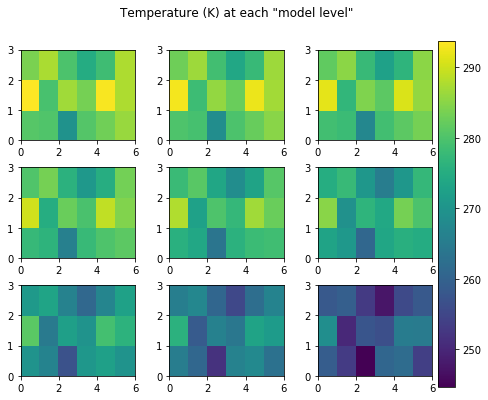

In [6]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(8, 6))
norm = plt.Normalize(vmin=temperature.min(), vmax=temperature.max())

for i in range(nz):
    plt.subplot(3, 3, i + 1)
    qm = plt.pcolormesh(temperature[i], cmap='viridis', norm=norm)

plt.subplots_adjust(right=0.84, wspace=0.3, hspace=0.3)
cax = plt.axes([0.85, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.suptitle('Temperature (K) at each "model level"')

plt.show()

#### Restratification / vertical interpolation

Our data is in the form:

 * 1d "model level" vertical coordinate (z axis)
 * 2 x 1d horizontal coordinates (x, y)
 * 3d "altitude" variable (x, y, z)
 * 3d "temperature" variable (x, y, z)
 
Suppose we now want to change the vertical coordinate system of our variables so that they are on levels of constant altitude, not levels of constant "model levels":

In [7]:
target_altitudes = np.linspace(700, 5500, 5)  # m

If we visualise this, we can see that we need to consider the behaviour for a number of situations, including what should happen when we are sampling *below the orography*, and when we are *above the model top*.

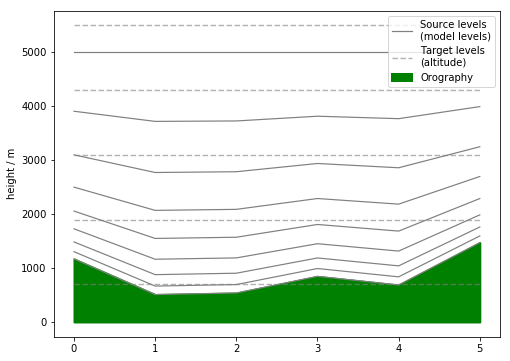

In [8]:
plt.figure(figsize=(8, 6))
plt.fill_between(np.arange(6), np.zeros(6), orography[1, :],
                 color='green', linewidth=2, label='Orography')

for i in range(9):
    plt.plot(altitude[i, 1, :],
             color='gray', lw=1.2,
             label=None if i > 0 else 'Source levels \n(model levels)')
for i, target in enumerate(target_altitudes):
    plt.plot(np.repeat(target, 6),
             color='gray', linestyle='--', lw=1.4, alpha=0.6,
             label=None if i > 0 else 'Target levels \n(altitude)')

plt.ylabel('height / m')
plt.margins(top=0.1)
plt.legend()
plt.savefig('summary.png')
plt.show()

The default behaviour depends on the scheme, but for linear interpolation we recieve NaNs both below the orography and above the model top:

In [9]:
import stratify

target_nz = 20
target_altitudes = np.linspace(400, 5200, target_nz)  # m

new_temperature = stratify.interpolate(target_altitudes, altitude, temperature,
                                       axis=0)

With some work, we can visualise this result to compare a cross-section before and after. In particular this will allow us to see precisely what the interpolator has done at the extremes of our target levels:

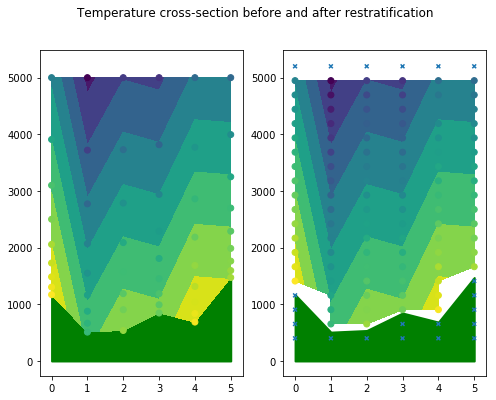

In [10]:
plt.figure(figsize=(8, 6))
ax1 = plt.subplot(1, 2, 1)
plt.fill_between(np.arange(6), np.zeros(6), orography[1, :],
                 color='green', linewidth=2, label='Orography')
cs = plt.contourf(np.tile(np.arange(6), nz).reshape(nz, 6),
             altitude[:, 1],
             temperature[:, 1])
plt.scatter(np.tile(np.arange(6), nz).reshape(nz, 6),
            altitude[:, 1],
            c=temperature[:, 1])

plt.subplot(1, 2, 2, sharey=ax1)
plt.fill_between(np.arange(6), np.zeros(6), orography[1, :],
                 color='green', linewidth=2, label='Orography')
plt.contourf(np.arange(6), target_altitudes,
             np.ma.masked_invalid(new_temperature[:, 1]),
             cmap=cs.cmap, norm=cs.norm)
plt.scatter(np.tile(np.arange(nx), target_nz).reshape(target_nz, nx),
            np.repeat(target_altitudes, nx).reshape(target_nz, nx),
            c=new_temperature[:, 1])
plt.scatter(np.tile(np.arange(nx), target_nz).reshape(target_nz, nx),
            np.repeat(target_altitudes, nx).reshape(target_nz, nx),
            s=np.isnan(new_temperature[:, 1]) * 15, marker='x')

plt.suptitle('Temperature cross-section before and after restratification')
plt.show()